In [220]:
## Print multiple output per cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [221]:
## Importing libraries
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn
tqdm.pandas()

In [222]:
## Pandas Display options
pd.set_option('display.max_columns',0)
pd.set_option('display.max_colwidth',0)

In [223]:
## Reading relevant data
match_lvl_data = pd.read_csv('match_level_scorecard.csv')
batsman_lvl_data = pd.read_csv('batsman_level_scorecard.csv')
bowler_lvl_data = pd.read_csv('bowler_level_scorecard.csv')
train_data = pd.read_csv('train_data_processed_02.csv')  #use the file from features_final_output
test_data = pd.read_csv('test_data_processed_02.csv') #use the file from features_final_output

train_data.shape
test_data.shape

(948, 41)

(271, 37)

In [224]:
from matplotlib import pyplot as plt
import re
import numpy as np

plt.style.use('ggplot')  # Change 'seaborn' to a built-in style like 'ggplot', 'classic', etc.

def createRnP(X_12, feature, N=5, ylim_lb=0.3, ylim_ub=0.7):
    '''
    Rank and Plot of input feature on the input data. The y-axis shows %team1 wins in each bucket.

    Parameters-
    1. X_12: dataset to build the RnP on. 
    2. feature: Feature to build RnP of.
    3. N: number of bins on x-axis. Default 5.
    4. ylim_lb: lower bound of y axis on plot.
    5. ylim_ub: upper bound of y axis on plot.

    Output-
    1. Rank and Plot

    Returns- None
    '''
    df = X_12.copy()
    df[f'{feature}_bin'] = df[feature].rank(pct=True)//(1/N) # divide feature values for all games in 5 equi-volume buckets.
    df['count'] = 1
    df['team1_win%'] = df['winner_01'].apply(lambda x: 1-x) # invert winner_01 to get team1 winner indicator
    df['team2_win%'] = df['winner_01'].copy()
    df[f'{feature}_min'] = df[feature].copy()
    df[f'{feature}_max'] = df[feature].copy()
    df_g = df.groupby(f'{feature}_bin').agg({'team1_win%':'mean', 'team2_win%':'mean', 'count':'sum', f'{feature}_min':'min',\
                                            f'{feature}_max':'max'}).reset_index()
    N = min(N,df_g.shape[0])
    blue_bar = df_g['team1_win%'].values.tolist()
    ind = np.arange(N)
    # plotting starts
    plt.figure(figsize=(10,5));
    plt.bar(ind, blue_bar, label='Team 1 win%');
    plt.axhline(y=0.5, linewidth=0.5, color='k', linestyle = '--')
    xlabel = re.sub('team_','ratio_',feature)
    plt.xlabel(f'{xlabel} (team1 / team2) bins');
    plt.ylabel('Win %');
    plt.title(f'RnP - {feature} vs win');
    df_g['xticks'] = df_g.apply(lambda x: str(round(x[f'{feature}_min'],2)) + ' - ' + str(round(x[f'{feature}_max'],2)), axis=1)
    plt.xticks(ind, df_g['xticks']);
    plt.ylim([ylim_lb,ylim_ub]);
    plt.legend(loc='best');
    x2,x1 = blue_bar[-1],blue_bar[0]
    slope = x2/x1
    if slope < 1:
        slope = 1/slope
        x1,x2 = x2,x1
    print('slope:', round(x2,2),'/',round(x1,2), '= ',round(slope,2))
    plt.show();


In [225]:
def giveLastNyrgamesPlayer(player_id, date, n, bat_or_bowl):
    '''
    Function to get last n games stats of a player before an input date.
    
    Input-
    1. player_id: id of the player to get historical data.
    2. date: date to look-back and get n games. Stats returned are before this input date.
    3. n: Number of historical games stats to return.
    4. bat_or_bowl: Kind of stats to return. {'bat': batting stats to return, 'bowl': bowling stats to return}
    
    Output-None
    
    Returns- dataframe having bowling/batting stats from last n games of a player before an input date. 
    The results are sorted by date.
    '''
    if bat_or_bowl == 'bat':
        df_topick = batsman_lvl_data
        id_col = 'batsman_id'
    else:
        df_topick = bowler_lvl_data
        id_col = 'bowler_id'

    df_topick['match_dt'] = pd.to_datetime(df_topick['match_dt'])
    # df_topick = df_topick[df_topick['match_dt'].dt.year == 2023]
    given_date = pd.to_datetime(date)
    one_year_ago = given_date - pd.DateOffset(years=n)

        
    # return df_topick[(df_topick['match_dt']<date)&(df_topick[id_col]==float(player_id))]\
    #             .sort_values(by='match_dt', ascending=False).head(n)
    return df_topick[(df_topick['match_dt'] >= one_year_ago) & (df_topick['match_dt'] < given_date) & (df_topick[id_col]==float(player_id))]\
            .sort_values(by='match_dt', ascending=False)


In [226]:
## Creating a binary winner column - 0 if team1 wins, else 1
train_data['winner_01'] = train_data.apply(lambda x: 0 if (x['team1']==x['winner']) else 1, axis=1)

# train_data.columns
# test_data.columns

# # batsman_lvl_data.info()
# # bowler_lvl_data.info()

### 6) bat_avg opponent (last 3)

In [227]:
def batavgAgainstTeamLastn(player_list, team_id, opponent_team_id, date, n, match_data):
    """
    Function to calculate the batting average of players in the roster of a team against a specific opponent in the last n games.
    
    Input:
    - player_list: A ':' separated list of player ids in the roster of a team.
    - team_id: The team ID of the current team.
    - opponent_team_id: The team ID of the opponent.
    - date: The match date of the game to calculate this feature.
    - n: Number of games to look back and create this feature.
    - match_data: DataFrame containing match data.
    
    Returns:
    - Average runs scored by all players in the roster against the specific opponent, or 0 if no matches are found.
    """
    player_list = str(player_list).split(':')
    res_list = []

    # Filter match_data for matches involving the current team and the opponent
    relevant_matches = match_data[((match_data['team1_id'] == team_id) & (match_data['team2_id'] == opponent_team_id)) | 
                                  ((match_data['team2_id'] == team_id) & (match_data['team1_id'] == opponent_team_id))]

    # Sort matches by date to get the most recent ones
    relevant_matches = relevant_matches.sort_values(by='match_dt', ascending=False)

    # Filter matches before the given date and take the last n matches
    relevant_matches = relevant_matches[relevant_matches['match_dt'] < date].head(n)

    if relevant_matches.empty:
        return 0

    for player in player_list:
        # Filter batting data for the current player in relevant matches
        df_rel = batsman_lvl_data[(batsman_lvl_data['match id'].isin(relevant_matches['match id'])) & 
                                  (batsman_lvl_data['batsman_id'] == float(player))]
        if df_rel.empty:
            res_list.append(0)
        else:
            df_rel['runs'] = pd.to_numeric(df_rel['runs'], errors='coerce')
            bat_avg_player = np.nanmean(df_rel['runs'])
            res_list.append(bat_avg_player)

    if len(res_list) == 0:
        return 0

    return np.nanmean(res_list)


In [228]:
from tqdm import tqdm

# Define the number of previous games to consider
n_previous_games = 3

# Calculate batting averages for team1 against the opponent
train_data['team1_bat_avg_opponent'] = train_data.progress_apply(lambda x: 
                                  calculate_team_bat_avg_opponent(x, n_previous_games)[0], axis=1)

# Calculate batting averages for team2 against the opponent
train_data['team2_bat_avg_opponent'] = train_data.progress_apply(lambda x: 
                                  calculate_team_bat_avg_opponent(x, n_previous_games)[1], axis=1)

# Calculate batting averages for team1 against the opponent
test_data['team1_bat_avg_opponent'] = test_data.progress_apply(lambda x: 
                                  calculate_team_bat_avg_opponent(x, n_previous_games)[0], axis=1)

# Calculate batting averages for team2 against the opponent
test_data['team2_bat_avg_opponent'] = test_data.progress_apply(lambda x: 
                                  calculate_team_bat_avg_opponent(x, n_previous_games)[1], axis=1)

100%|██████████| 271/271 [00:01<00:00, 139.98it/s]


In [229]:
train_data['bat_avg_opponent_diff'] = train_data['team1_bat_avg_opponent'] - train_data['team2_bat_avg_opponent']
train_data.drop(['team1_bat_avg_opponent','team2_bat_avg_opponent'], axis= True, inplace=True)

In [230]:
test_data['bat_avg_opponent_diff'] = test_data['team1_bat_avg_opponent'] - test_data['team2_bat_avg_opponent']
test_data.drop(['team1_bat_avg_opponent','team2_bat_avg_opponent'], axis= True, inplace=True)

slope: 0.6 / 0.45 =  1.33


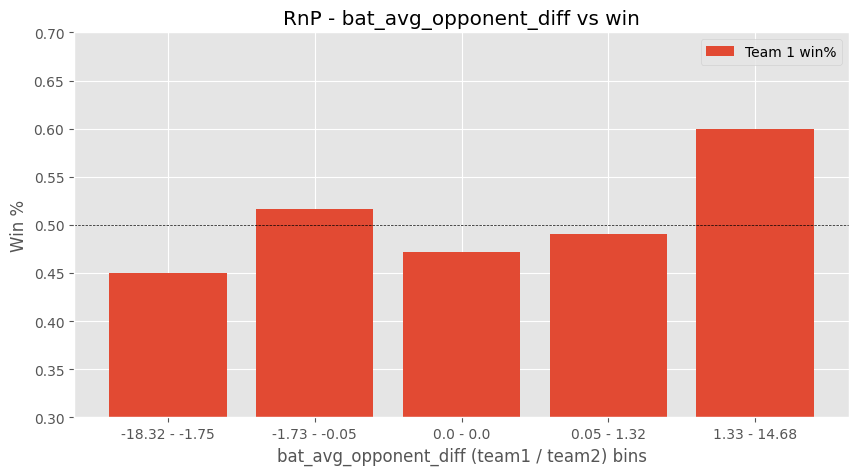

In [231]:
createRnP(train_data, 'bat_avg_opponent_diff')

### 1) milestones against oponent by last 3 matches

In [232]:
from tqdm import tqdm
import numpy as np
import pandas as pd

def runs_Lastn_opponent(player_list, team_id, opponent_team_id, date, n, run, match_data):
    """
    Function to calculate the total number of instances where players in the roster of a team
    scored runs within a specific range in the last n games against a specific opponent.
    
    Inputs:
    - player_list: A ':' separated list of player IDs in the roster of a team.
    - team_id: The team ID of the current team.
    - opponent_team_id: The team ID of the opponent.
    - date: The match date of the game to calculate this feature.
    - n: Number of games to look back and create this feature.
    - run: The threshold for the runs scored by players to be counted within the specified range.
    - match_data: DataFrame containing match data.
    
    Returns:
    - Total number of instances where players in the roster scored runs within the specified range
      against the specific opponent in the last n games.
    """
    player_list = str(player_list).split(':')
    res_list = []

    # Define the upper bound for runs based on the specified threshold
    run_u = float('inf')
    if run == 30:
        run_u = 50
    if run == 50:
        run_u = 100

    # Filter match_data for matches between the current team and the opponent
    relevant_matches = match_data[((match_data['team1_id'] == team_id) & (match_data['team2_id'] == opponent_team_id)) | 
                                  ((match_data['team2_id'] == team_id) & (match_data['team1_id'] == opponent_team_id))]

    relevant_matches = relevant_matches[relevant_matches['match_dt'] < date].sort_values(by='match_dt', ascending=False).head(n)

    if relevant_matches.empty:
        return 0

    for player in player_list:
        milestone_score = 0
        for match_id in relevant_matches['match id']:
            df_rel = batsman_lvl_data[(batsman_lvl_data['match id'] == match_id) & 
                                      (batsman_lvl_data['batsman_id'] == float(player))]
            df_rel['runs'] = pd.to_numeric(df_rel['runs'], errors='coerce')
            df_rel['gte_runs'] = np.where((df_rel['runs'] >= run) & (df_rel['runs'] < run_u), 1, 0)
            if not df_rel.empty:
                milestone_score += df_rel['gte_runs'].sum()
        res_list.append(milestone_score)

    return sum(res_list)

# Apply the function to train_data
train_data['team1_50_opponent'] = train_data.progress_apply(lambda x: 
            runs_Lastn_opponent(player_list=x['team1_roster_ids'], team_id=x['team1_id'], opponent_team_id=x['team2_id'], 
                                date=x['match_dt'], n=3, run=50, match_data=match_lvl_data), axis=1)
train_data['team2_50_opponent'] = train_data.progress_apply(lambda x: 
            runs_Lastn_opponent(player_list=x['team2_roster_ids'], team_id=x['team2_id'], opponent_team_id=x['team1_id'], 
                                date=x['match_dt'], n=3, run=50, match_data=match_lvl_data), axis=1)

train_data['team1_100_opponent'] = train_data.progress_apply(lambda x: 
            runs_Lastn_opponent(player_list=x['team1_roster_ids'], team_id=x['team1_id'], opponent_team_id=x['team2_id'], 
                                date=x['match_dt'], n=3, run=100, match_data=match_lvl_data), axis=1)
train_data['team2_100_opponent'] = train_data.progress_apply(lambda x: 
            runs_Lastn_opponent(player_list=x['team2_roster_ids'], team_id=x['team2_id'], opponent_team_id=x['team1_id'], 
                                date=x['match_dt'], n=3, run=100, match_data=match_lvl_data), axis=1)

train_data['team1_30_opponent'] = train_data.progress_apply(lambda x: 
            runs_Lastn_opponent(player_list=x['team1_roster_ids'], team_id=x['team1_id'], opponent_team_id=x['team2_id'], 
                                date=x['match_dt'], n=3, run=30, match_data=match_lvl_data), axis=1)
train_data['team2_30_opponent'] = train_data.progress_apply(lambda x: 
            runs_Lastn_opponent(player_list=x['team2_roster_ids'], team_id=x['team2_id'], opponent_team_id=x['team1_id'], 
                                date=x['match_dt'], n=3, run=30, match_data=match_lvl_data), axis=1)


100%|██████████| 948/948 [00:15<00:00, 60.42it/s]


In [233]:
# Apply the function to test_data
test_data['team1_50_opponent'] = test_data.progress_apply(lambda x: 
            runs_Lastn_opponent(player_list=x['team1_roster_ids'], team_id=x['team1_id'], opponent_team_id=x['team2_id'], 
                                date=x['match_dt'], n=3, run=50, match_data=match_lvl_data), axis=1)
test_data['team2_50_opponent'] = test_data.progress_apply(lambda x: 
            runs_Lastn_opponent(player_list=x['team2_roster_ids'], team_id=x['team2_id'], opponent_team_id=x['team1_id'], 
                                date=x['match_dt'], n=3, run=50, match_data=match_lvl_data), axis=1)

test_data['team1_100_opponent'] = test_data.progress_apply(lambda x: 
            runs_Lastn_opponent(player_list=x['team1_roster_ids'], team_id=x['team1_id'], opponent_team_id=x['team2_id'], 
                                date=x['match_dt'], n=3, run=100, match_data=match_lvl_data), axis=1)
test_data['team2_100_opponent'] = test_data.progress_apply(lambda x: 
            runs_Lastn_opponent(player_list=x['team2_roster_ids'], team_id=x['team2_id'], opponent_team_id=x['team1_id'], 
                                date=x['match_dt'], n=3, run=100, match_data=match_lvl_data), axis=1)

test_data['team1_30_opponent'] = test_data.progress_apply(lambda x: 
            runs_Lastn_opponent(player_list=x['team1_roster_ids'], team_id=x['team1_id'], opponent_team_id=x['team2_id'], 
                                date=x['match_dt'], n=3, run=30, match_data=match_lvl_data), axis=1)
test_data['team2_30_opponent'] = test_data.progress_apply(lambda x: 
            runs_Lastn_opponent(player_list=x['team2_roster_ids'], team_id=x['team2_id'], opponent_team_id=x['team1_id'], 
                                date=x['match_dt'], n=3, run=30, match_data=match_lvl_data), axis=1)

100%|██████████| 271/271 [00:04<00:00, 60.53it/s]


In [234]:
# Taking the ratio of 50 runs for train_data
train_data['team_50_opp'] = (train_data['team1_50_opponent'])-(train_data['team2_50_opponent'] + 0.1)
train_data.drop(columns=['team1_50_opponent', 'team2_50_opponent'], inplace=True)  # Dropping intermediate columns

# Taking the ratio of 100 runs for train_data
train_data['team_100_opp'] = (train_data['team1_100_opponent'])-(train_data['team2_100_opponent'] + 0.1)
train_data.drop(columns=['team1_100_opponent', 'team2_100_opponent'], inplace=True)  # Dropping intermediate columns

# Taking the ratio of 30 runs for train_data
train_data['team_30_opp'] = (train_data['team1_30_opponent'])-(train_data['team2_30_opponent'] + 0.1)
train_data.drop(columns=['team1_30_opponent', 'team2_30_opponent'], inplace=True)  # Dropping intermediate columns

# Taking the ratio of 50 runs for test_data
test_data['team_50_opp'] = (test_data['team1_50_opponent'])-(test_data['team2_50_opponent'] + 0.1)
test_data.drop(columns=['team1_50_opponent', 'team2_50_opponent'], inplace=True)  # Dropping intermediate columns

# Taking the ratio of 100 runs for test_data
test_data['team_100_opp'] = (test_data['team1_100_opponent'])-(test_data['team2_100_opponent'] + 0.1)
test_data.drop(columns=['team1_100_opponent', 'team2_100_opponent'], inplace=True)  # Dropping intermediate columns

# Taking the ratio of 30 runs for test_data
test_data['team_30_opp'] = (test_data['team1_30_opponent'])-(test_data['team2_30_opponent'] + 0.1)
test_data.drop(columns=['team1_30_opponent', 'team2_30_opponent'], inplace=True)  # Dropping intermediate columns

slope: 0.56 / 0.47 =  1.19


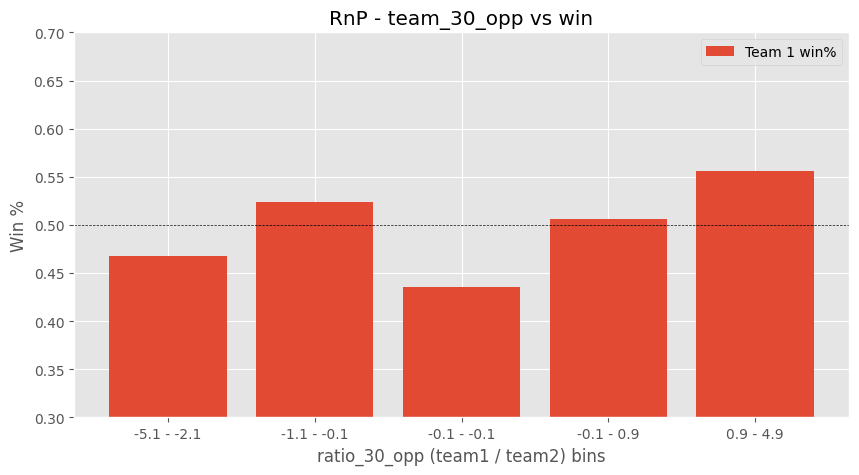

In [235]:
createRnP(train_data, 'team_30_opp')

slope: 0.56 / 0.47 =  1.19


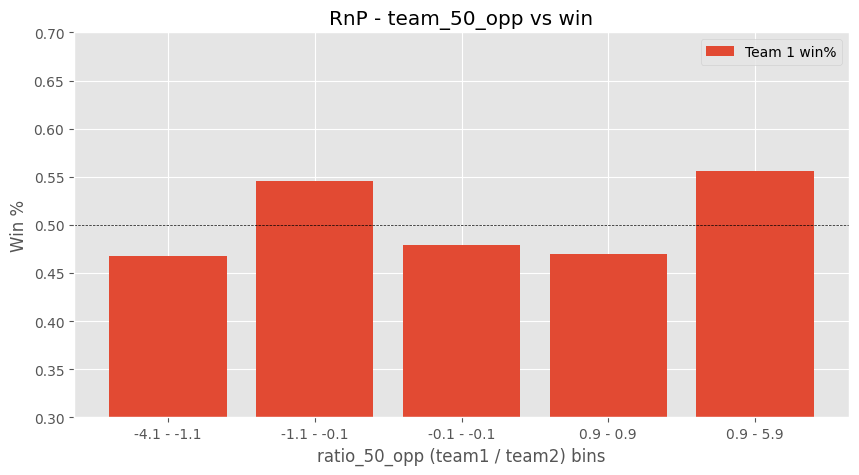

In [236]:
createRnP(train_data, 'team_50_opp')

slope: 0.56 / 0.49 =  1.14


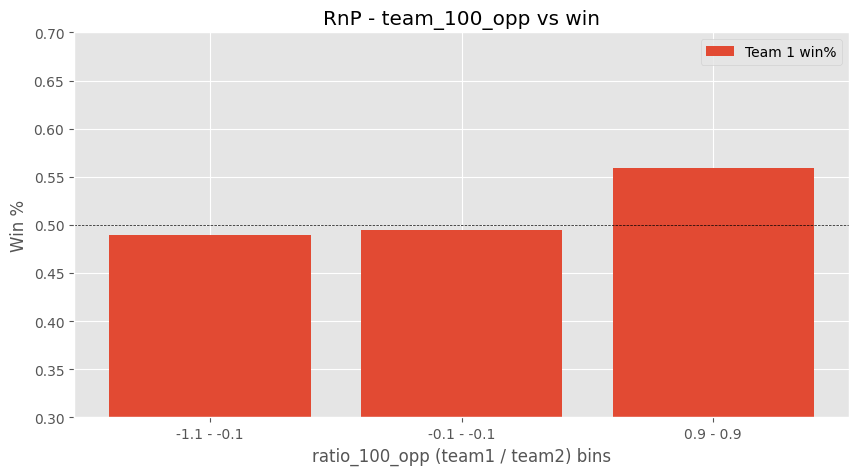

In [237]:
createRnP(train_data, 'team_100_opp')

### 7) strike rate opponent last 3 matches

In [238]:
def batstrLastn_opponent(player_list, team_id, opponent_team_id, date, n, match_data):
    """
    Function to calculate the batting strike rate of players in the roster of a team
    against a specific opponent in the last n games.
    
    Inputs:
    - player_list: A ':' separated list of player IDs in the roster of a team.
    - team_id: The team ID of the current team.
    - opponent_team_id: The team ID of the opponent.
    - date: The match date of the game to calculate this feature.
    - n: Number of games to look back and create this feature.
    - match_data: DataFrame containing match data.
    
    Returns:
    - Average strike rate of all players in the roster against the specific opponent.
    """
    player_list = str(player_list).split(':')
    res_list = []

    # Filter match_data for matches between the current team and the opponent
    relevant_matches = match_data[((match_data['team1_id'] == team_id) & (match_data['team2_id'] == opponent_team_id)) | 
                                  ((match_data['team2_id'] == team_id) & (match_data['team1_id'] == opponent_team_id))]

    relevant_matches = relevant_matches[relevant_matches['match_dt'] < date].sort_values(by='match_dt', ascending=False).head(n)

    if relevant_matches.empty:
        return 0

    for player in player_list:
        total_runs = 0
        total_balls_faced = 0
        for match_id in relevant_matches['match id']:
            df_rel = batsman_lvl_data[(batsman_lvl_data['match id'] == match_id) & 
                                      (batsman_lvl_data['batsman_id'] == float(player))]
            df_rel['runs'] = pd.to_numeric(df_rel['runs'], errors='coerce')
            df_rel['balls_faced'] = pd.to_numeric(df_rel['balls_faced'], errors='coerce')

            total_runs += df_rel['runs'].sum()
            total_balls_faced += df_rel['balls_faced'].sum()

        if total_balls_faced > 0:
            strike_rate_avg = (total_runs / total_balls_faced) * 100
        else:
            strike_rate_avg = 0
        
        res_list.append(strike_rate_avg)

    return np.nanmean(res_list)

# Apply the function to train_data
train_data['team1_bat_strike_rate_opponent'] = train_data.progress_apply(lambda x: 
            batstrLastn_opponent(player_list=x['team1_roster_ids'], team_id=x['team1_id'], opponent_team_id=x['team2_id'], 
                                 date=x['match_dt'], n=3, match_data=match_lvl_data), axis=1)
train_data['team2_bat_strike_rate_opponent'] = train_data.progress_apply(lambda x: 
            batstrLastn_opponent(player_list=x['team2_roster_ids'], team_id=x['team2_id'], opponent_team_id=x['team1_id'], 
                                 date=x['match_dt'], n=3, match_data=match_lvl_data), axis=1)

# Calculate the difference in strike rates for train_data
train_data['bat_strike_rate_opponent'] = train_data['team1_bat_strike_rate_opponent'] - train_data['team2_bat_strike_rate_opponent']

# Drop the intermediate columns in train_data
train_data.drop(columns=['team1_bat_strike_rate_opponent', 'team2_bat_strike_rate_opponent'], inplace=True)




100%|██████████| 948/948 [00:11<00:00, 83.12it/s] 


In [239]:
# Apply the function to test_data
test_data['team1_bat_strike_rate_opponent'] = test_data.progress_apply(lambda x: 
            batstrLastn_opponent(player_list=x['team1_roster_ids'], team_id=x['team1_id'], opponent_team_id=x['team2_id'], 
                                 date=x['match_dt'], n=3, match_data=match_lvl_data), axis=1)
test_data['team2_bat_strike_rate_opponent'] = test_data.progress_apply(lambda x: 
            batstrLastn_opponent(player_list=x['team2_roster_ids'], team_id=x['team2_id'], opponent_team_id=x['team1_id'], 
                                 date=x['match_dt'], n=3, match_data=match_lvl_data), axis=1)

# Calculate the difference in strike rates for test_data
test_data['bat_strike_rate_opponent'] = test_data['team1_bat_strike_rate_opponent'] - test_data['team2_bat_strike_rate_opponent']

# Drop the intermediate columns in test_data
test_data.drop(columns=['team1_bat_strike_rate_opponent', 'team2_bat_strike_rate_opponent'], inplace=True)

100%|██████████| 271/271 [00:03<00:00, 82.44it/s]


slope: 0.57 / 0.46 =  1.25


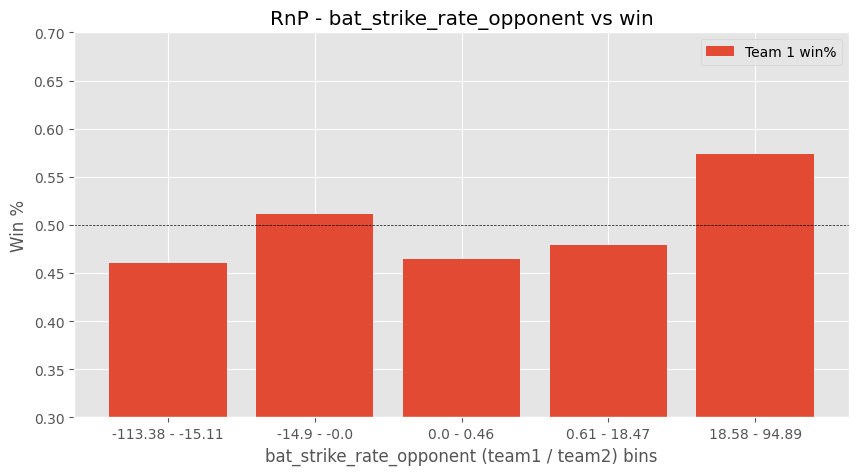

In [240]:
createRnP(train_data, 'bat_strike_rate_opponent')

### 8) team_strength opponent

In [241]:

train_data['team_batting_strength_opp'] = 0.5*train_data['bat_avg_opponent_diff'] + 0.3*train_data['bat_strike_rate_opponent']

In [242]:

test_data['team_batting_strength_opp'] = 0.5*test_data['bat_avg_opponent_diff'] + 0.3*test_data['bat_strike_rate_opponent']

slope: 0.56 / 0.46 =  1.23


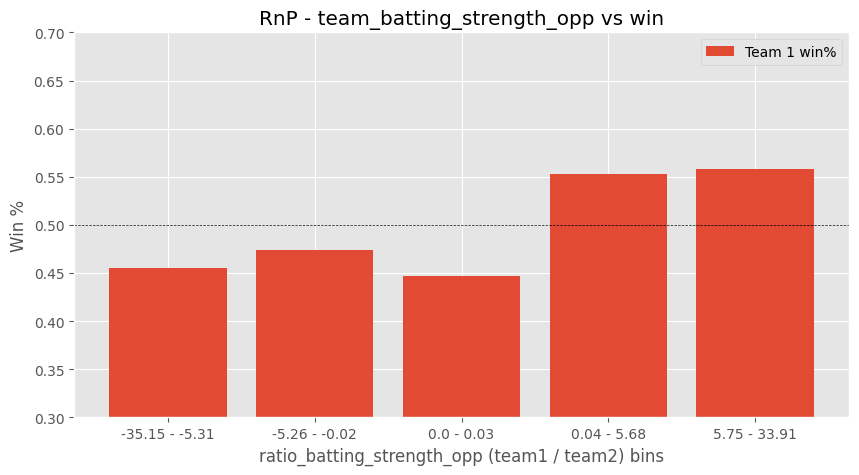

In [243]:
createRnP(train_data, 'team_batting_strength_opp')

### 9) bowl avg against opponent

In [244]:
def bowlavgLastn_opponent(player_list, team_id, opponent_team_id, date, n, match_data):
    """
    Function to calculate the bowling average of players in the roster of a team
    against a specific opponent in the last n games.
    
    Inputs:
    - player_list: A ':' separated list of player IDs in the roster of a team.
    - team_id: The team ID of the current team.
    - opponent_team_id: The team ID of the opponent.
    - date: The match date of the game to calculate this feature.
    - n: Number of games to look back and create this feature.
    - match_data: DataFrame containing match data.
    
    Returns:
    - Average bowling economy of all players in the roster against the specific opponent.
    """
    player_list = str(player_list).split(':')
    res_list = []

    # Filter match_data for matches between the current team and the opponent
    relevant_matches = match_data[((match_data['team1_id'] == team_id) & (match_data['team2_id'] == opponent_team_id)) | 
                                  ((match_data['team2_id'] == team_id) & (match_data['team1_id'] == opponent_team_id))]

    relevant_matches = relevant_matches[relevant_matches['match_dt'] < date].sort_values(by='match_dt', ascending=False).head(n)

    if relevant_matches.empty:
        return 0

    for player in player_list:
        total_runs = 0
        total_wickets = 0
        for match_id in relevant_matches['match id']:
            df_rel = bowler_lvl_data[(bowler_lvl_data['match id'] == match_id) & 
                                     (bowler_lvl_data['bowler_id'] == float(player))]
            df_rel['runs'] = pd.to_numeric(df_rel['runs'], errors='coerce')
            df_rel['wicket_count'] = pd.to_numeric(df_rel['wicket_count'], errors='coerce')

            total_runs += df_rel['runs'].sum()
            total_wickets += df_rel['wicket_count'].sum()

        economy = total_runs / (total_wickets + 0.1)
        res_list.append(economy)

    return np.nanmean(res_list)

# Apply the function to train_data
train_data['team1_bowl_avg_opponent'] = train_data.progress_apply(lambda x: 
            bowlavgLastn_opponent(player_list=x['team1_roster_ids'], team_id=x['team1_id'], opponent_team_id=x['team2_id'], 
                                  date=x['match_dt'], n=3, match_data=match_lvl_data), axis=1)
train_data['team2_bowl_avg_opponent'] = train_data.progress_apply(lambda x: 
            bowlavgLastn_opponent(player_list=x['team2_roster_ids'], team_id=x['team2_id'], opponent_team_id=x['team1_id'], 
                                  date=x['match_dt'], n=3, match_data=match_lvl_data), axis=1)

# Calculate the difference in bowling averages for train_data
train_data['bowl_avg_opponent'] = train_data['team1_bowl_avg_opponent'] - train_data['team2_bowl_avg_opponent']

# Drop the intermediate columns in train_data
train_data.drop(columns=['team1_bowl_avg_opponent', 'team2_bowl_avg_opponent'], inplace=True)

100%|██████████| 948/948 [00:11<00:00, 79.49it/s] 


In [245]:
# Apply the function to test_data
test_data['team1_bowl_avg_opponent'] = test_data.progress_apply(lambda x: 
            bowlavgLastn_opponent(player_list=x['team1_roster_ids'], team_id=x['team1_id'], opponent_team_id=x['team2_id'], 
                                  date=x['match_dt'], n=3, match_data=match_lvl_data), axis=1)
test_data['team2_bowl_avg_opponent'] = test_data.progress_apply(lambda x: 
            bowlavgLastn_opponent(player_list=x['team2_roster_ids'], team_id=x['team2_id'], opponent_team_id=x['team1_id'], 
                                  date=x['match_dt'], n=3, match_data=match_lvl_data), axis=1)

# Calculate the difference in bowling averages for test_data
test_data['bowl_avg_opponent'] = test_data['team1_bowl_avg_opponent'] - test_data['team2_bowl_avg_opponent']

# Drop the intermediate columns in test_data
test_data.drop(columns=['team1_bowl_avg_opponent', 'team2_bowl_avg_opponent'], inplace=True)

100%|██████████| 271/271 [00:03<00:00, 89.34it/s] 


slope: 0.52 / 0.52 =  1.01


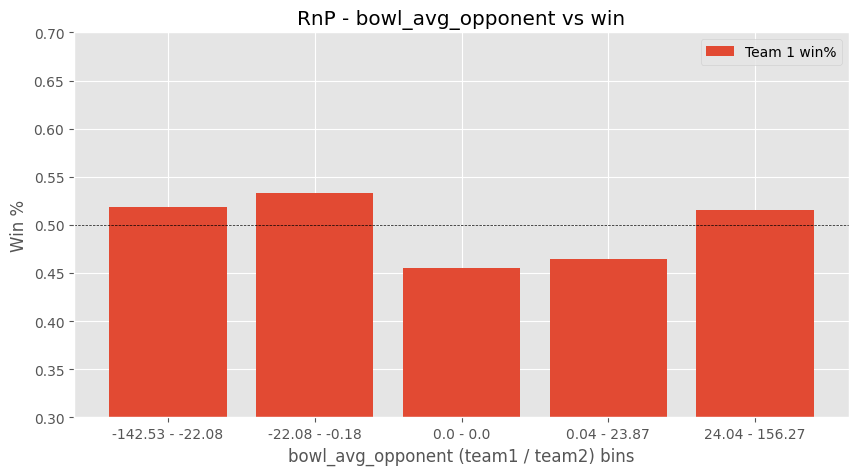

In [246]:
createRnP(train_data, 'bowl_avg_opponent')

### 10) bowl strike rate

In [247]:
def bowlstrLastn_opponent(player_list, team_id, opponent_team_id, date, n, match_data):
    """
    Function to calculate the bowling strike rate of players in the roster of a team
    against a specific opponent in the last n games.
    
    Inputs:
    - player_list: A ':' separated list of player IDs in the roster of a team.
    - team_id: The team ID of the current team.
    - opponent_team_id: The team ID of the opponent.
    - date: The match date of the game to calculate this feature.
    - n: Number of games to look back and create this feature.
    - match_data: DataFrame containing match data.
    
    Returns:
    - Average bowling strike rate of all players in the roster against the specific opponent.
    """
    player_list = str(player_list).split(':')
    res_list = []

    # Filter match_data for matches between the current team and the opponent
    relevant_matches = match_data[((match_data['team1_id'] == team_id) & (match_data['team2_id'] == opponent_team_id)) | 
                                  ((match_data['team2_id'] == team_id) & (match_data['team1_id'] == opponent_team_id))]

    relevant_matches = relevant_matches[relevant_matches['match_dt'] < date].sort_values(by='match_dt', ascending=False).head(n)

    if relevant_matches.empty:
        return 0

    for player in player_list:
        total_balls_bowled = 0
        total_wickets = 0
        for match_id in relevant_matches['match id']:
            df_rel = bowler_lvl_data[(bowler_lvl_data['match id'] == match_id) & 
                                     (bowler_lvl_data['bowler_id'] == float(player))]
            df_rel['balls_bowled'] = pd.to_numeric(df_rel['balls_bowled'], errors='coerce')
            df_rel['wicket_count'] = pd.to_numeric(df_rel['wicket_count'], errors='coerce')

            total_balls_bowled += df_rel['balls_bowled'].sum()
            total_wickets += df_rel['wicket_count'].sum()

        if total_wickets > 0:
            bowl_str = total_balls_bowled / total_wickets
        else:
            bowl_str = 0
        
        res_list.append(bowl_str)

    return np.nanmean(res_list)

# Apply the function to train_data
train_data['team1_bowl_strike_rate_opponent'] = train_data.progress_apply(lambda x: 
            bowlstrLastn_opponent(player_list=x['team1_roster_ids'], team_id=x['team1_id'], opponent_team_id=x['team2_id'], 
                                  date=x['match_dt'], n=3, match_data=match_lvl_data), axis=1)
train_data['team2_bowl_strike_rate_opponent'] = train_data.progress_apply(lambda x: 
            bowlstrLastn_opponent(player_list=x['team2_roster_ids'], team_id=x['team2_id'], opponent_team_id=x['team1_id'], 
                                  date=x['match_dt'], n=3, match_data=match_lvl_data), axis=1)

# Calculate the difference in bowling strike rates for train_data
train_data['bowl_strike_rate_opponent'] = train_data['team1_bowl_strike_rate_opponent'] - train_data['team2_bowl_strike_rate_opponent']

# Drop the intermediate columns in train_data
train_data.drop(columns=['team1_bowl_strike_rate_opponent', 'team2_bowl_strike_rate_opponent'], inplace=True)


100%|██████████| 948/948 [00:11<00:00, 79.37it/s] 


In [248]:
# Apply the function to test_data
test_data['team1_bowl_strike_rate_opponent'] = test_data.progress_apply(lambda x: 
            bowlstrLastn_opponent(player_list=x['team1_roster_ids'], team_id=x['team1_id'], opponent_team_id=x['team2_id'], 
                                  date=x['match_dt'], n=3, match_data=match_lvl_data), axis=1)
test_data['team2_bowl_strike_rate_opponent'] = test_data.progress_apply(lambda x: 
            bowlstrLastn_opponent(player_list=x['team2_roster_ids'], team_id=x['team2_id'], opponent_team_id=x['team1_id'], 
                                  date=x['match_dt'], n=3, match_data=match_lvl_data), axis=1)

# Calculate the difference in bowling strike rates for test_data
test_data['bowl_strike_rate_opponent'] = test_data['team1_bowl_strike_rate_opponent'] - test_data['team2_bowl_strike_rate_opponent']

# Drop the intermediate columns in test_data
test_data.drop(columns=['team1_bowl_strike_rate_opponent', 'team2_bowl_strike_rate_opponent'], inplace=True)

100%|██████████| 271/271 [00:03<00:00, 77.19it/s]


slope: 0.52 / 0.5 =  1.04


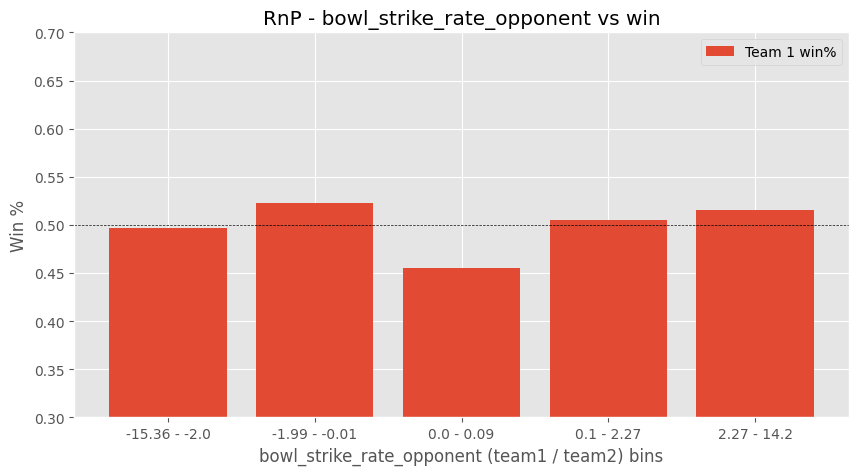

In [249]:
createRnP(train_data, 'bowl_strike_rate_opponent')

### 11) economy agains opponent

In [250]:
def bowlecoLastn_opponent(player_list, team_id, opponent_team_id, date, n, match_data):
    """
    Function to calculate the bowling economy of players in the roster of a team
    against a specific opponent in the last n games.
    
    Inputs:
    - player_list: A ':' separated list of player IDs in the roster of a team.
    - team_id: The team ID of the current team.
    - opponent_team_id: The team ID of the opponent.
    - date: The match date of the game to calculate this feature.
    - n: Number of games to look back and create this feature.
    - match_data: DataFrame containing match data.
    
    Returns:
    - Average bowling economy of all players in the roster against the specific opponent.
    """
    player_list = str(player_list).split(':')
    res_list = []

    # Filter match_data for matches between the current team and the opponent
    relevant_matches = match_data[((match_data['team1_id'] == team_id) & (match_data['team2_id'] == opponent_team_id)) | 
                                  ((match_data['team2_id'] == team_id) & (match_data['team1_id'] == opponent_team_id))]

    relevant_matches = relevant_matches[relevant_matches['match_dt'] < date].sort_values(by='match_dt', ascending=False).head(n)

    if relevant_matches.empty:
        return 0

    for player in player_list:
        total_runs = 0
        total_balls_bowled = 0
        for match_id in relevant_matches['match id']:
            df_rel = bowler_lvl_data[(bowler_lvl_data['match id'] == match_id) & 
                                     (bowler_lvl_data['bowler_id'] == float(player))]
            df_rel['runs'] = pd.to_numeric(df_rel['runs'], errors='coerce')
            df_rel['balls_bowled'] = pd.to_numeric(df_rel['balls_bowled'], errors='coerce')

            total_runs += df_rel['runs'].sum()
            total_balls_bowled += df_rel['balls_bowled'].sum()

        if total_balls_bowled > 0:
            economy = total_runs / (total_balls_bowled / 6)
        else:
            economy = 0
        
        res_list.append(economy)

    return np.nanmean(res_list)

# Apply the function to train_data
train_data['team1_bowl_eco_opponent'] = train_data.progress_apply(lambda x: 
            bowlecoLastn_opponent(player_list=x['team1_roster_ids'], team_id=x['team1_id'], opponent_team_id=x['team2_id'], 
                                  date=x['match_dt'], n=3, match_data=match_lvl_data), axis=1)
train_data['team2_bowl_eco_opponent'] = train_data.progress_apply(lambda x: 
            bowlecoLastn_opponent(player_list=x['team2_roster_ids'], team_id=x['team2_id'], opponent_team_id=x['team1_id'], 
                                  date=x['match_dt'], n=3, match_data=match_lvl_data), axis=1)

# Calculate the difference in bowling economies for train_data
train_data['bowl_eco_opponent'] = train_data['team1_bowl_eco_opponent'] - train_data['team2_bowl_eco_opponent']

# Drop the intermediate columns in train_data
train_data.drop(columns=['team1_bowl_eco_opponent', 'team2_bowl_eco_opponent'], inplace=True)



100%|██████████| 948/948 [00:11<00:00, 79.82it/s] 


In [251]:
# Apply the function to test_data
test_data['team1_bowl_eco_opponent'] = test_data.progress_apply(lambda x: 
            bowlecoLastn_opponent(player_list=x['team1_roster_ids'], team_id=x['team1_id'], opponent_team_id=x['team2_id'], 
                                  date=x['match_dt'], n=3, match_data=match_lvl_data), axis=1)
test_data['team2_bowl_eco_opponent'] = test_data.progress_apply(lambda x: 
            bowlecoLastn_opponent(player_list=x['team2_roster_ids'], team_id=x['team2_id'], opponent_team_id=x['team1_id'], 
                                  date=x['match_dt'], n=3, match_data=match_lvl_data), axis=1)

# Calculate the difference in bowling economies for test_data
test_data['bowl_eco_opponent'] = test_data['team1_bowl_eco_opponent'] - test_data['team2_bowl_eco_opponent']

# Drop the intermediate columns in test_data
test_data.drop(columns=['team1_bowl_eco_opponent', 'team2_bowl_eco_opponent'], inplace=True)


100%|██████████| 271/271 [00:03<00:00, 81.36it/s]


slope: 0.53 / 0.5 =  1.06


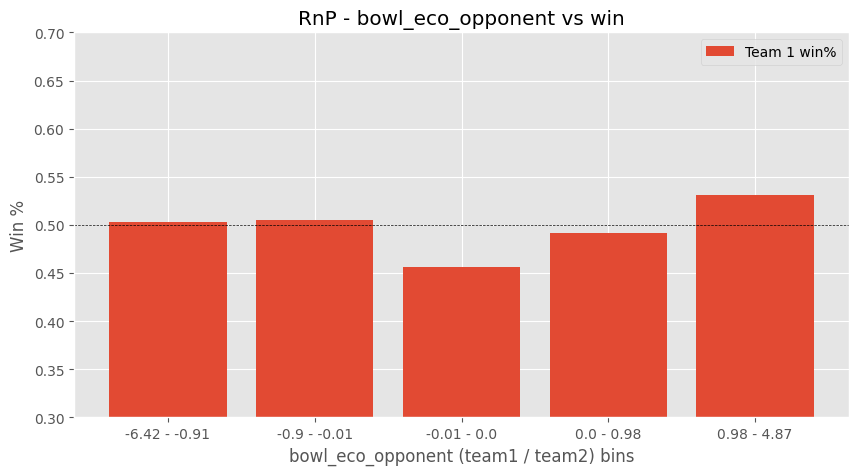

In [252]:
createRnP(train_data, 'bowl_eco_opponent')

### New) wickets taken 

In [253]:
def wicketsLastn_opponent(player_list, team_id, opponent_team_id, date, n, match_data):
    """
    Function to calculate the average wickets taken by players in the roster of a team
    against a specific opponent in the last n games.
    
    Inputs:
    - player_list: A ':' separated list of player IDs in the roster of a team.
    - team_id: The team ID of the current team.
    - opponent_team_id: The team ID of the opponent.
    - date: The match date of the game to calculate this feature.
    - n: Number of games to look back and create this feature.
    - match_data: DataFrame containing match data.
    
    Returns:
    - Average wickets taken by all players in the roster against the specific opponent.
    """
    player_list = str(player_list).split(':')
    res_list = []

    # Filter match_data for matches between the current team and the opponent
    relevant_matches = match_data[((match_data['team1_id'] == team_id) & (match_data['team2_id'] == opponent_team_id)) | 
                                  ((match_data['team2_id'] == team_id) & (match_data['team1_id'] == opponent_team_id))]

    relevant_matches = relevant_matches[relevant_matches['match_dt'] < date].sort_values(by='match_dt', ascending=False).head(n)

    if relevant_matches.empty:
        return 0

    for player in player_list:
        total_wickets = 0
        for match_id in relevant_matches['match id']:
            df_rel = bowler_lvl_data[(bowler_lvl_data['match id'] == match_id) & 
                                     (bowler_lvl_data['bowler_id'] == float(player))]
            df_rel['wicket_count'] = pd.to_numeric(df_rel['wicket_count'], errors='coerce')

            total_wickets += df_rel['wicket_count'].sum()

        res_list.append(total_wickets)

    return np.nanmean(res_list)

# Apply the function to train_data
train_data['team1_wickets_opponent'] = train_data.progress_apply(lambda x: 
            wicketsLastn_opponent(player_list=x['team1_roster_ids'], team_id=x['team1_id'], opponent_team_id=x['team2_id'], 
                                  date=x['match_dt'], n=3, match_data=match_lvl_data), axis=1)
train_data['team2_wickets_opponent'] = train_data.progress_apply(lambda x: 
            wicketsLastn_opponent(player_list=x['team2_roster_ids'], team_id=x['team2_id'], opponent_team_id=x['team1_id'], 
                                  date=x['match_dt'], n=3, match_data=match_lvl_data), axis=1)

# Calculate the difference in wickets taken for train_data
train_data['wickets_lastn_opponent_diff'] = train_data['team1_wickets_opponent'] - train_data['team2_wickets_opponent']

# Drop the intermediate columns in train_data
train_data.drop(columns=['team1_wickets_opponent', 'team2_wickets_opponent'], inplace=True)

100%|██████████| 948/948 [00:09<00:00, 102.75it/s]


In [254]:
# Apply the function to test_data
test_data['team1_wickets_opponent'] = test_data.progress_apply(lambda x: 
            wicketsLastn_opponent(player_list=x['team1_roster_ids'], team_id=x['team1_id'], opponent_team_id=x['team2_id'], 
                                  date=x['match_dt'], n=3, match_data=match_lvl_data), axis=1)
test_data['team2_wickets_opponent'] = test_data.progress_apply(lambda x: 
            wicketsLastn_opponent(player_list=x['team2_roster_ids'], team_id=x['team2_id'], opponent_team_id=x['team1_id'], 
                                  date=x['match_dt'], n=3, match_data=match_lvl_data), axis=1)

# Calculate the difference in wickets taken for test_data
test_data['wickets_lastn_opponent_diff'] = test_data['team1_wickets_opponent'] - test_data['team2_wickets_opponent']

# Drop the intermediate columns in test_data
test_data.drop(columns=['team1_wickets_opponent', 'team2_wickets_opponent'], inplace=True)

100%|██████████| 271/271 [00:02<00:00, 112.92it/s]


slope: 0.59 / 0.47 =  1.25


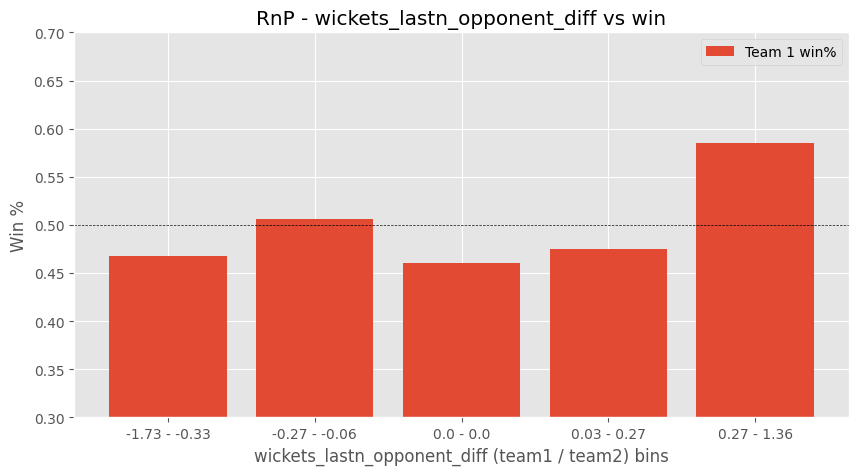

In [255]:
createRnP(train_data, 'wickets_lastn_opponent_diff')

### 12) bowling strength opponent

In [256]:
train_data['bowl_strength_opponent'] = 0.2*train_data['bowl_eco_opponent'] + 0.2*train_data['bowl_strike_rate_opponent'] + 0.4*train_data['wickets_lastn_opponent_diff']
test_data['bowl_strength_opponent'] = 0.2*test_data['bowl_eco_opponent'] + 0.2*test_data['bowl_strike_rate_opponent'] + 0.4*test_data['wickets_lastn_opponent_diff']

slope: 0.54 / 0.51 =  1.07


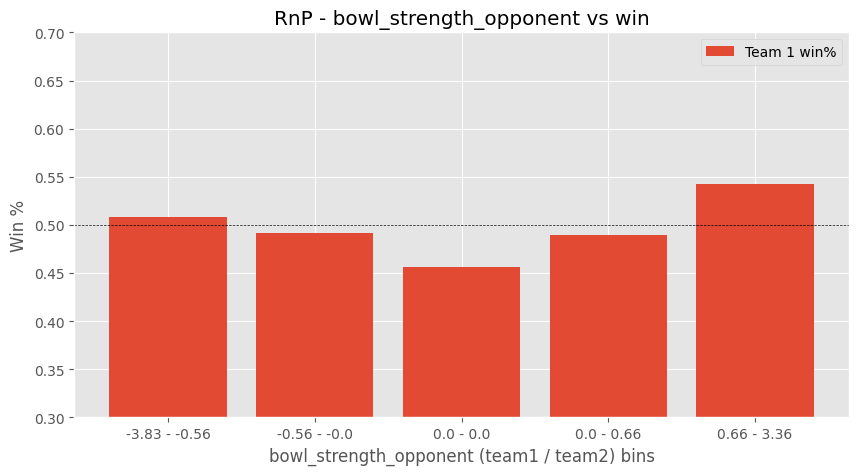

In [257]:
createRnP(train_data, 'bowl_strength_opponent')

In [258]:
# train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271 entries, 0 to 270
Data columns (total 48 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   match id                     271 non-null    int64  
 1   team1                        271 non-null    object 
 2   team1_id                     271 non-null    int64  
 3   team1_roster_ids             271 non-null    object 
 4   team2                        271 non-null    object 
 5   team2_id                     271 non-null    int64  
 6   team2_roster_ids             271 non-null    object 
 7   toss winner                  271 non-null    object 
 8   toss decision                271 non-null    object 
 9   venue                        271 non-null    object 
 10  city                         271 non-null    object 
 11  match_dt                     271 non-null    object 
 12  lighting                     271 non-null    object 
 13  series_name         

In [259]:
train_data.to_csv('train_data_processed_f_01.csv', index=False)
test_data.to_csv('test_data_processed_f_01.csv', index=False)